<a href="https://colab.research.google.com/github/abeebyekeen/DLforBeginners/blob/main/day1_session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#day 1 session 2: nonlinearity, activation function and multi-layer networks

**overview**:
In this session we demonstrate that, for datasets that are not separable by a straight line, our linear classifier is unable to perform well. Therefore it is necessary to introduce nonlinearity into the classifier model. We could of course be creative and design a perceptron with a single non-linear customized layer for each of such dataset. However, it would be more appealing if we can build models with simple, standardized and reusable "nonlinearity" components, so we don't have to rely on our mathematical instinct, luck and try-and-error each time. Also, real world problems could be way more complicated than our toy models, and designing nonlinear layers for each problem could be simply prohibitive. Furthermore, such complicated problems could require a combination of many such linear and non-linear building blocks in various shapes, quantities and orders. And this is what deep neural networks seem like.

**tasks**:
1. visualize dataset #2 & #3; reason whether the linear classfier from previous session would work on them; test it
2. come up with a customized 1-layer model for dataset #2 and reach perfect accuracy
3. come up with a customized 1-layer model for dataset #3 and reach perfect accuracy
4. implement an MLP and use it on dataset #2
5. implement an MLP and use it on dataset #3



##part 0: dependencies and functions

utility code that you don't have to read

In [ ]:
# dependencies
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Javascript

In [ ]:
# function for visualizing dataset
def visualize_data(X,Y,figuretitle):
    fig = plt.figure()
    ax = plt.gca()
    C0 = ax.scatter(X[Y==0,0],X[Y==0,1],c='b')
    C1 = ax.scatter(X[Y==1,0],X[Y==1,1],c='r')
    #c = ['b' if Y[i]==0 else 'r' for i in range(len(Y))]
    #scatter = ax.scatter(X[:,0], X[:,1], c=c)
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    legend1 = ax.legend((C0,C1),('y=0','y=1'),loc='upper left',)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.title(figuretitle)
    plt.plot()

In [ ]:
# function for visualizing loss function
def visualize_loss(Jout, w0_start, w0_end, w1_start, w1_end, step):
    x = np.arange(w0_start - 0.5*step, w0_end + 1.0*step, step)
    y = np.arange(w1_start - 0.5*step, w1_end + 1.0*step, step)
    z = Jout
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z)
    ax.set_aspect('equal')
    ax.set_xticks(x[:-1]+0.5*step)
    ax.set_yticks(y[:-1]+0.5*step)
    fig.colorbar(c, ax=ax)

In [ ]:
#modified from a piece of code from erwan-simon: "https://gist.github.com/erwan-simon/e3baef06a00bb9a39a6968acf78121ee"
#from torch.autograd import Variable
def plot_decision_boundary(X,Y,w,model):
    dataset= X
    labels = Y
    color_map='Paired'
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    x0min, x0max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    x1min, x1max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x0_span = np.linspace(x0min, x0max, steps)
    x1_span = np.linspace(x1min, x1max, steps)
    x0s, x1s = np.meshgrid(x0_span, x1_span)

    # Make predictions across region of interest
    #model.eval()
    #labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))
    labels_predicted = model(w, np.c_[x0s.ravel(), x1s.ravel()])
    # Plot decision boundary in region of interest
    #labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(x0s.shape)

    fig, ax = plt.subplots()
    contourf_ = ax.contourf(x0s, x1s, z, cmap=color_map, alpha=0.5)
    cbar = fig.colorbar(contourf_)
    #cbar.set_clim( vmin, vmax )

    # Get predicted labels on training data and plot
    #train_labels_predicted = model(dataset)

    C0 = ax.scatter(X[Y==0,0],X[Y==0,1],c='b')
    C1 = ax.scatter(X[Y==1,0],X[Y==1,1],c='r')
    ax.set_aspect('equal')
    #ax.set(xlim=(-3, 3), ylim=(-3, 3))
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.title("infering data, true labels, decision bounary")
    plt.plot()

In [ ]:
# print the rates of TN, FP, FN, TP, and ACC
def evaluate(Y,Y_pred):
    total = len(Y)
    TN = np.count_nonzero(np.logical_and(Y==0.0,Y_pred==0.0)) / total
    FP = np.count_nonzero(np.logical_and(Y==0.0,Y_pred==1.0)) / total
    FN = np.count_nonzero(np.logical_and(Y==1.0,Y_pred==0.0)) / total
    TP = np.count_nonzero(np.logical_and(Y==1.0,Y_pred==1.0)) / total
    ACC = TN+TP
    print('TN rate:',TN,', FP rate: ',FP,', FN rate: ',FN,', TP rate: ',TP)
    print('ACC=',ACC)

In [ ]:
# function for creating a binary classification dataset
def create_data_2(N):
    r0 = np.random.rand(N).astype(np.float32)+1.0
    r1 = np.random.rand(N).astype(np.float32)+3.0
    theta0 = (np.random.rand(N)-0.5).astype(np.float32) * 2.0 * np.pi
    theta1 = (np.random.rand(N)-0.5).astype(np.float32) * 2.0 * np.pi
    X0 = np.column_stack((r0*np.cos(theta0),r0*np.sin(theta0)))
    X1 = np.column_stack((r1*np.cos(theta1),r1*np.sin(theta1)))
    X = np.concatenate((X0,X1), axis=0)
    Y0 = np.zeros((N)).astype(np.float32)
    Y1 = np.ones( (N)).astype(np.float32)
    Y = np.concatenate((Y0,Y1))
    # shuffle X and Y
    new_id = np.random.permutation(2*N)
    X = X[new_id]
    Y = Y[new_id]
    return X,Y

In [ ]:
# function for creating a binary classification dataset
def create_data_3(N):
    X1 = np.random.rand(N,2).astype(np.float32)
    X2 = np.random.rand(N,2).astype(np.float32)
    X3 = np.random.rand(N,2).astype(np.float32)
    X4 = np.random.rand(N,2).astype(np.float32)
    X2[:,0] = X2[:,0] - 1.0
    X3 = X3 - 1.0
    X4[:,1] = X4[:,1] - 1.0
    X = np.concatenate((X1,X2,X3,X4), axis=0)
    Y1 = np.zeros((N)).astype(np.float32)
    Y2 = np.ones( (N)).astype(np.float32)
    Y3 = np.zeros((N)).astype(np.float32)
    Y4 = np.ones( (N)).astype(np.float32)
    Y = np.concatenate((Y1,Y2,Y3,Y4), axis=0)
    # shuffle X and Y
    new_id = np.random.permutation(4*N)
    X = X[new_id]
    Y = Y[new_id]
    return X,Y

##part 1: build your own classifier for a dataset #2 & #3





<IPython.core.display.Javascript object>

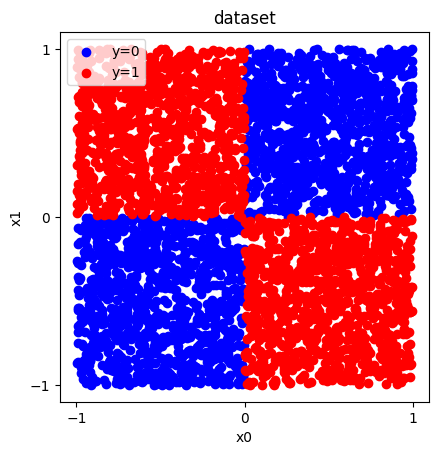

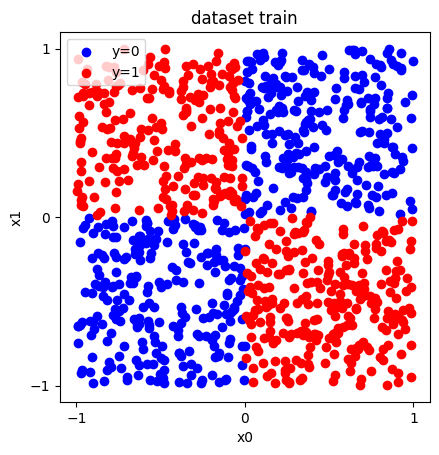

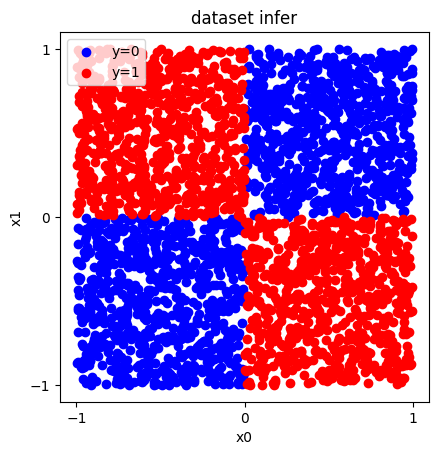

In [ ]:
SEED = 2023
np.random.seed(SEED)
N=1000
#X,Y=create_data_2(N)
X,Y=create_data_3(N)
X_train = X[:N]
Y_train = Y[:N]
X_infer = X[N:]
Y_infer = Y[N:]
#visualize
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 9999})'''))
visualize_data(X,Y,"dataset")
visualize_data(X_train,Y_train,"dataset train")
visualize_data(X_infer,Y_infer,"dataset infer")

In [ ]:
# build a classifier model
def MyClassifier(w, x):
    h = x[:,0]*x[:,1]
    y = h < 0
    return y

In [ ]:
# formulate performance evaluation function
def MyErrorRate(w,x,y):
    y_pred = MyClassifier(w, x)
    diff = np.logical_xor(y, y_pred)
    error_rate = diff.sum() / len(diff)
    return error_rate

In [ ]:
# train
w0_start, w0_end, w1_start, w1_end, step = -4, 4, -4, 4, 0.5
rranges = (slice(w0_start, w0_end+step, step), slice(w1_start, w1_end+step, step))
w_opt, fval, grid, Jout = scipy.optimize.brute(MyErrorRate, ranges=rranges, args=(X_train, Y_train), full_output=True, finish=None, disp=False, workers=1)
print(w_opt)
print(fval)
print(grid)
print(Jout)


[-4. -4.]
0.0
[[[-4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
   -4.  -4.  -4. ]
  [-3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5
   -3.5 -3.5 -3.5]
  [-3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.
   -3.  -3.  -3. ]
  [-2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5
   -2.5 -2.5 -2.5]
  [-2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
   -2.  -2.  -2. ]
  [-1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5
   -1.5 -1.5 -1.5]
  [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1. ]
  [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
   -0.5 -0.5 -0.5]
  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0. ]
  [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
    0.5  0.5  0.5]
  [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.

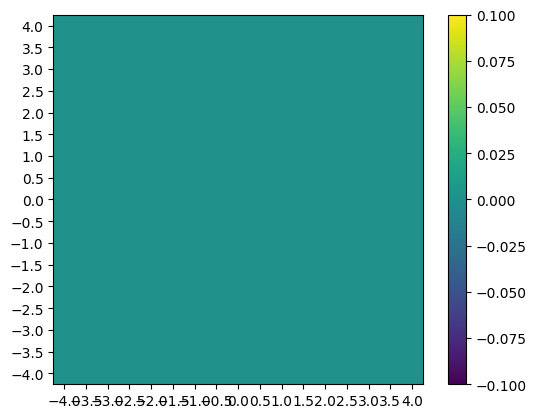

In [ ]:
visualize_loss(Jout, w0_start,w0_end,w1_start,w1_end,step)

In [ ]:
Y_infer_pred = MyClassifier(w_opt, X_infer)

In [ ]:
evaluate(Y_infer,Y_infer_pred)

TN rate: 0.49833333333333335 , FP rate:  0.0 , FN rate:  0.0 , TP rate:  0.5016666666666667
ACC= 1.0


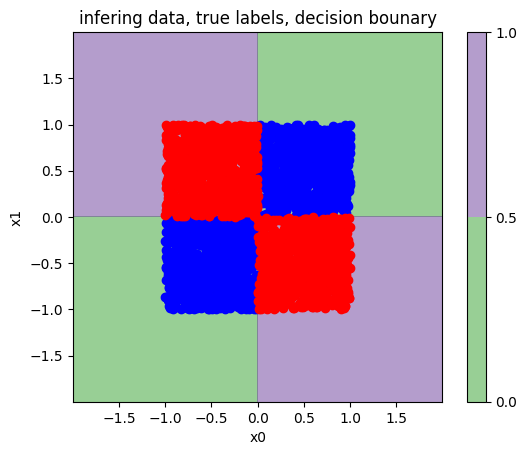

In [ ]:
plot_decision_boundary(X_infer,Y_infer_pred,w_opt,MyClassifier)